<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/4Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
#df = df[df['n/m'] != 2]
print(df.shape[0])

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

8750


In [2]:
X_modified = X.drop([ 'median', 'range', 'k', 'max', 'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','m'], axis = 1)
print(X_modified.head())
#X_modified = X.drop(['max', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'av.length'], axis = 1)

     n    n/m   av.length    std.dev
0   18   3.00  106.500000  55.454536
1   66   2.75  279.787872  64.138435
2   44   2.75   76.295456  14.908371
3  110  11.00   60.145454  23.781048
4   44  11.00   59.409092  21.935762


In [3]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

1655304


In [4]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({1167: 1416, 865: 1416, 273: 1416, 396: 1416, 3723: 1416, 2137: 1416, 2945: 1416, 3635: 1416, 400: 1416, 360: 1416, 2361: 1416, 1011: 1416, 1696: 1416, 1022: 1416, 2556: 1416, 1940: 1416, 580: 1416, 602: 1416, 1765: 1416, 841: 1416, 832: 1416, 926: 1416, 1051: 1416, 1722: 1416, 2035: 1416, 3293: 1416, 1868: 1416, 1459: 1416, 974: 1416, 385: 1416, 706: 1416, 1920: 1416, 785: 1416, 1305: 1416, 2801: 1416, 222: 1416, 517: 1416, 89: 1416, 122: 1416, 382: 1416, 2429: 1416, 392: 1416, 137: 1416, 307: 1416, 104: 1416, 1529: 1416, 3800: 1416, 662: 1416, 1493: 1416, 372: 1416, 24: 1416, 1248: 1416, 355: 1416, 299: 1416, 29: 1416, 1626: 1416, 200: 1416, 3686: 1416, 980: 1416, 1146: 1416, 1026: 1416, 383: 1416, 1668: 1416, 2307: 1416, 1798: 1416, 600: 1416, 860: 1416, 2822: 1416, 790: 1416, 1478: 1416, 912: 1416, 3417: 1416, 1979: 1416, 1029: 1416, 3650: 1416, 253: 1416, 621: 1416, 3901: 1416, 904: 1416, 428: 1416, 1945: 1416, 3388: 1416, 219: 1416, 1182: 1416, 2087: 1416, 363: 1416, 2356

In [5]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow
from tensorflow import keras 


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,1))
    return 99999*1/(1+K.exp(-x))

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.1))

    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(16, activation = 'relu'))

    #model.add(Dense(32, activation='relu'))

    #model.add(Dense(64, activation='relu'))

    #model.add(Dense(4, activation='relu'))
    
    model.add(Dense(1, activation = custom_activation))
    #model.add(Activation(custom_activation, name='SpecialActivation'))
    model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(clipnorm=1))
    #model.compile(loss='mean_squared_error', optimizer='RMSProp')

    return model

In [6]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=10, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train)
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/10
10734/10734 [==============================] - 32s 3ms/step - loss: 12169935.0000
Epoch 2/10
10734/10734 [==============================] - 24s 2ms/step - loss: 2529670.0000
Epoch 3/10
10734/10734 [==============================] - 22s 2ms/step - loss: 1964384.0000
Epoch 4/10
10734/10734 [==============================] - 22s 2ms/step - loss: 1967883.8750
Epoch 5/10
10734/10734 [==============================] - 26s 2ms/step - loss: 1870214.3750
Epoch 6/10
10734/10734 [==============================] - 24s 2ms/step - loss: 1883171.7500
Epoch 7/10
10734/10734 [==============================] - 23s 2ms/step - loss: 1882339.6250
Epoch 8/10
10734/10734 [==============================] - 22s 2ms/step - loss: 1744904.5000
Epoch 9/10
10734/10734 [==============================] - 22s 2ms/step - loss: 1772108.7500
Epoch 10/10
10734/10734 [==============================] - 22s 2ms/step - loss: 1779789.8750


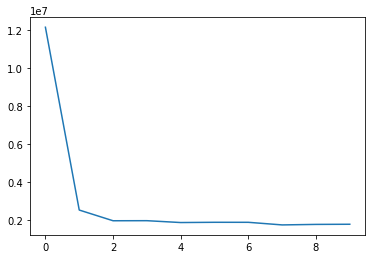

In [7]:
plt.plot(history.history['loss'])

In [8]:
#from sklearn.metrics import r2_score
#prediction = estimator.predict(X_val)
#print("r_square score: ", r2_score(y_val,prediction))
##y_test = sc2.inverse_transform(y_test.reshape(-1,1))
#yy = np.array(y_val)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
#predd = np.array(prediction)
#for i in range(len(yy)):
#  if(yy[i]-predd[i] > 99000):
#    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))

In [9]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt

#print("RMSE:")
#sqrt(mean_squared_error(yy, predd)) 

In [10]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
for i in range(len(yy)):
  if(yy[i]-predd[i] > 99000):
    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))

2199/2199 [==============================] - 4s 2ms/step
r_square score:  0.7955198849222639
real value of y_test: 99999 -> the predict: 41.973953
real value of y_test: 99999 -> the predict: 40.733677
real value of y_test: 99999 -> the predict: 39.89487
real value of y_test: 99999 -> the predict: 39.37798
real value of y_test: 99999 -> the predict: 39.456738
real value of y_test: 99999 -> the predict: 40.505608


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd)) 

RMSE:


1407.5378522691658